In [25]:
import numpy as np 
import os
from tqdm.auto import tqdm
from PIL import Image
import torch

In [2]:
highest_positions = []
for idx in tqdm(range(2000)):
    sh_coeff = np.load(f"../../datasets/face/face2000_single_viz/ball_front_fullscale/{idx:05d}.npy")
    sh_gray = 0.299*sh_coeff[..., 0]  + 0.587*sh_coeff[..., 1] + 0.114*sh_coeff[..., 2]
    highest_position = np.unravel_index(np.argmax(sh_gray), sh_gray.shape)
    highest_positions.append(highest_position)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [3]:
highest_positions

[(42, 33),
 (20, 196),
 (20, 59),
 (89, 249),
 (59, 20),
 (1, 143),
 (59, 235),
 (96, 4),
 (6, 166),
 (143, 1),
 (20, 196),
 (20, 59),
 (172, 126),
 (143, 254),
 (20, 196),
 (112, 254),
 (251, 159),
 (96, 251),
 (20, 59),
 (166, 6),
 (20, 59),
 (112, 254),
 (143, 254),
 (6, 166),
 (112, 254),
 (112, 1),
 (59, 235),
 (20, 196),
 (64, 238),
 (166, 249),
 (4, 159),
 (112, 254),
 (96, 251),
 (96, 4),
 (20, 196),
 (112, 254),
 (59, 20),
 (59, 235),
 (112, 1),
 (1, 143),
 (64, 17),
 (101, 25),
 (56, 22),
 (20, 59),
 (1, 143),
 (96, 251),
 (6, 166),
 (186, 115),
 (96, 251),
 (143, 254),
 (6, 89),
 (89, 249),
 (4, 96),
 (20, 196),
 (112, 1),
 (20, 196),
 (143, 254),
 (79, 24),
 (112, 254),
 (112, 254),
 (42, 33),
 (112, 254),
 (96, 251),
 (89, 249),
 (1, 112),
 (96, 4),
 (1, 143),
 (7, 169),
 (96, 251),
 (6, 166),
 (196, 235),
 (1, 143),
 (59, 235),
 (89, 249),
 (143, 254),
 (20, 196),
 (112, 254),
 (6, 166),
 (143, 254),
 (143, 254),
 (6, 89),
 (159, 251),
 (251, 96),
 (159, 251),
 (112, 1),


In [5]:
# calculate distance from the most buttom 
highest_positions = np.array(highest_positions)
distance_from_bottom = highest_positions.copy()
distance_from_bottom[:, 0] = 255 - distance_from_bottom[:, 0]
distance_from_bottom[:, 1] = 127.5 - distance_from_bottom[:, 1]
distance_from_bottom = np.linalg.norm(distance_from_bottom, axis=1)


In [7]:
distance_from_bottom

array([232.81967271, 244.64055265, 244.64055265, ..., 252.90709757,
       168.5823241 , 220.41097976])

In [8]:
sorted_indices = distance_from_bottom.argsort()

In [9]:
sorted_indices[:10]

array([ 824, 1481,  542,  489, 1095,  346,  401,  291,   82, 1784])

In [17]:
distance_from_bottom[542]

15.033296378372908

In [20]:
highest_positions[1737]

array([42, 33])

In [42]:
def create_image_grid(images):
  """Creates an image grid of size 4x4 from a list of 16 PIL.Images.

  Args:
      images: A list of 16 PIL.Image objects.

  Returns:
      A new PIL.Image object containing the image grid.
  """
  if len(images) != 16:
    raise ValueError("List must contain exactly 16 images.")

  # Find the maximum width and height of the images
  max_width = max(image.size[0] for image in images)
  max_height = max(image.size[1] for image in images)

  # Calculate the total width and height of the grid
  grid_width = 4 * max_width
  grid_height = 4 * max_height

  # Create a new image for the grid
  grid_image = Image.new('RGB', size=(grid_width, grid_height))

  # Paste each image into the grid with padding
  for i, image in enumerate(images):
    row = i // 4
    col = i % 4
    x_offset = col * max_width
    y_offset = row * max_height

    # Paste the image with padding to center it within its grid cell
    paste_box = (x_offset + (max_width - image.size[0]) // 2,
                 y_offset + (max_height - image.size[1]) // 2,
                 x_offset + max_width,
                 y_offset + max_height)
    grid_image.paste(image, box=paste_box)

  return grid_image

In [43]:
image_out = []
for idx in sorted_indices[:16]:
    subdir = idx // 1000 * 1000
    img = Image.open(f"../../datasets/face/face2000_single/images/{subdir:05d}/{idx:05d}.png")
    gt_img = img.resize((256,256))
    sh_coeff = np.load(f"../../datasets/face/face2000_single_viz/ball_front_fullscale/{idx:05d}.npy")
    sh_coeff = np.clip(sh_coeff / np.percentile(sh_coeff,99.9), 0, 1)
    pos = highest_positions[idx]
    WIDTH = 5
    sh_coeff[pos[0]-WIDTH:pos[0]+WIDTH, pos[1]-WIDTH:pos[1]+WIDTH, 0] = 1
    sh_coeff[pos[0]-WIDTH:pos[0]+WIDTH, pos[1]-WIDTH:pos[1]+WIDTH, 1] = 0
    sh_coeff[pos[0]-WIDTH:pos[0]+WIDTH, pos[1]-WIDTH:pos[1]+WIDTH, 2] = 0
    sh_coeff = (sh_coeff * 255).astype(np.uint8)
    sh_coeff = Image.fromarray(sh_coeff)
    #sh_coeff = Image.open(f"../../datasets/face/face2000_single_viz/ball_bright_dark_back/{subdir:05d}/{idx:05d}.png")
    sh_coeff = sh_coeff.resize((256,256))
    img = Image.new("RGB", (512, 256))
    img.paste(sh_coeff, (0,0))
    img.paste(gt_img, (256,0))
    #print(highest_positions[idx])
    image_out.append(img)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [44]:
image_gird = create_image_grid(image_out)

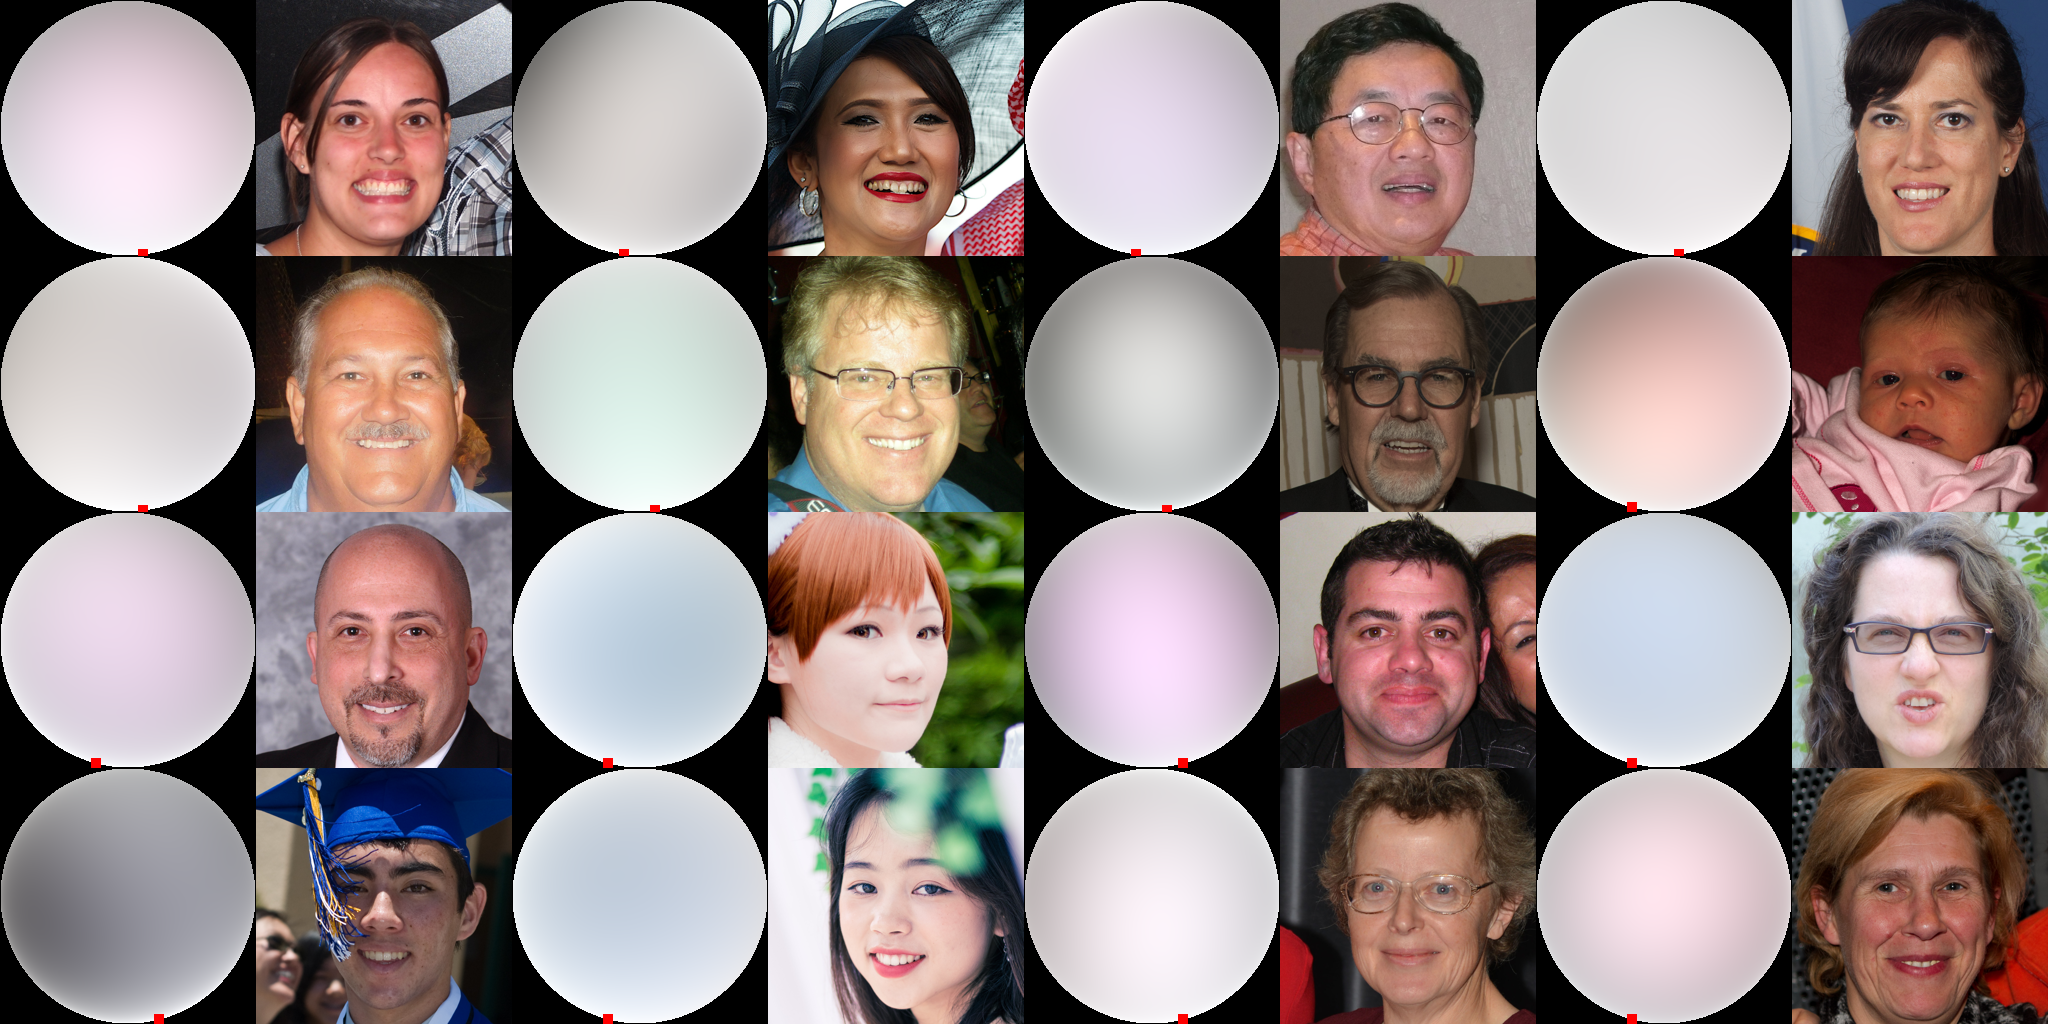

In [45]:
display(image_gird)

In [28]:
def log_map_to_range(arr):
    """
    Maps an array containing values from 0 to positive infinity to [0, 1]
    using logarithmic scaling with the maximum value as 1, using PyTorch.

    Args:
        arr: A PyTorch tensor of floats.

    Returns:
        A PyTorch tensor of floats, scaled to the range [0, 1].
    """

    # Convert to PyTorch tensor if needed
    if not torch.is_tensor(arr):
        arr = torch.tensor(arr)
    m_arr = arr.clone() 

    # Handle potential zeros (replace with a small positive value)
    eps = np.finfo(float).eps
    arr = torch.clamp(arr, min=eps)
    
    # Find the maximum value (avoiding NaNs)
    max_value = torch.max(arr)
    print("MAX VALUE:", max_value)

    if np.abs(max_value-1.0) < 1e-6:
        # No scaling needed
        scaled_arr = arr
    else:
        # Apply logarithmic scaling (base-10 for clarity)
        scaled_arr = torch.log10(arr) / torch.log10(max_value)

    # Clip to ensure values are within [0, 1] (optional)
    scaled_arr = torch.clamp(scaled_arr, min=0, max=1)

    return scaled_arr

MAX VALUE: tensor(1.3845)
[254 143]


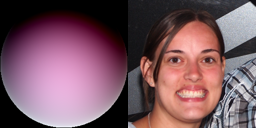

MAX VALUE: tensor(1.2788)
[254 112]


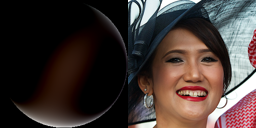

MAX VALUE: tensor(1.2572)
[254 112]


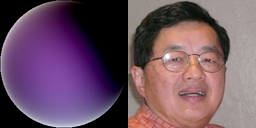

MAX VALUE: tensor(1.3021)
[254 143]


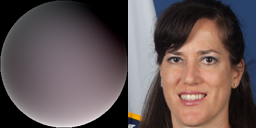

MAX VALUE: tensor(1.4462)
[254 143]


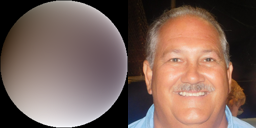

MAX VALUE: tensor(1.5149)
[254 143]


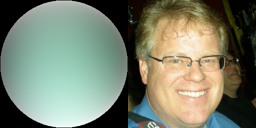

MAX VALUE: tensor(1.0108)
[254 143]


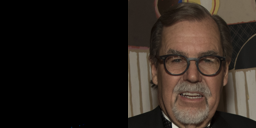

MAX VALUE: tensor(1.0414)
[251  96]


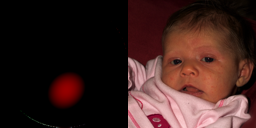

MAX VALUE: tensor(1.3493)
[251  96]


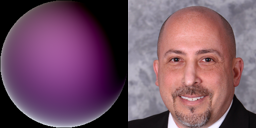

MAX VALUE: tensor(1.6167)
[251  96]


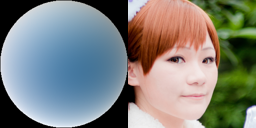

MAX VALUE: tensor(1.2581)
[251 159]


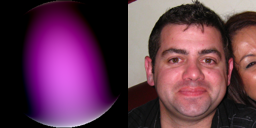

MAX VALUE: tensor(1.4734)
[251  96]


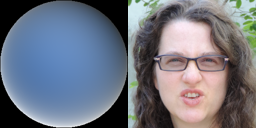

MAX VALUE: tensor(1.3156)
[251 159]


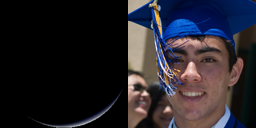

MAX VALUE: tensor(1.5525)
[251  96]


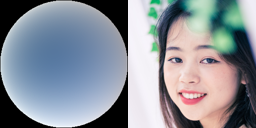

MAX VALUE: tensor(1.1744)
[251 159]


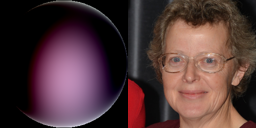

MAX VALUE: tensor(1.0324)
[251  96]


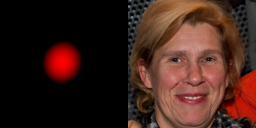

MAX VALUE: tensor(1.2394)
[249 166]


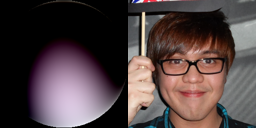

MAX VALUE: tensor(1.2363)
[249 166]


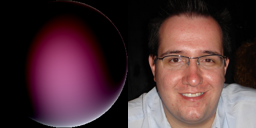

MAX VALUE: tensor(1.3680)
[249 166]


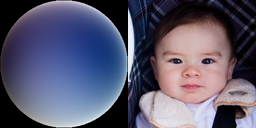

MAX VALUE: tensor(1.1117)
[249 166]


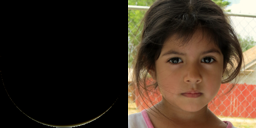

In [33]:
for idx in sorted_indices[:20]:
    subdir = idx // 1000 * 1000
    img = Image.open(f"../../datasets/face/face2000_single/images/{subdir:05d}/{idx:05d}.png")
    gt_img = img.resize((128,128))
    sh_coeff = np.load(f"../../datasets/face/face2000_single_viz/ball_front_fullscale/{idx:05d}.npy")
    sh_coeff = log_map_to_range(sh_coeff*1.2).numpy()
    #sh_coeff = np.clip(sh_coeff / np.percentile(sh_coeff,99.9), 0, 1)
    sh_coeff = (sh_coeff * 255).astype(np.uint8)
    sh_coeff = Image.fromarray(sh_coeff)
    sh_coeff = sh_coeff.resize((128,128))
    img = Image.new("RGB", (256, 128))
    img.paste(sh_coeff, (0,0))
    img.paste(gt_img, (128,0))
    print(highest_positions[idx])
    display(img)